In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, learning_curve, StratifiedKFold
from sklearn.metrics import precision_recall_curve

#from sklearn.metrics import plot_roc_curve
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

import joblib


In [2]:
df = pd.read_csv('preprocessed_new_phishing.csv')

In [3]:
# Separate the label column
label_column = 'label'  # Ensure this is the actual name of your label column

# Check for each column if it can predict the label perfectly
predictive_columns = []

for column in df.columns:
    if column != label_column:
        # Create a mapping of feature values to labels
        feature_label_mapping = df.groupby(column)[label_column].nunique()
        
        # If each feature value maps to exactly one unique label, it is a perfect predictor
        if feature_label_mapping.max() == 1:
            predictive_columns.append(column)

# Output the features that perfectly predict the label
print("Features that can perfectly predict the label:")
print(predictive_columns)

Features that can perfectly predict the label:
[]


In [4]:
df.columns

Index(['hops', 'missing_subject', 'missing_date', 'missing_message-id',
       'missing_from', 'missing_return-path', 'missing_to',
       'missing_content-type', 'missing_mime-version',
       'missing_content-transfer-encoding', 'missing_x-mimeole',
       'missing_list-id', 'missing_x-virus-scanned', 'missing_status',
       'missing_content-length', 'missing_precedence', 'missing_delivered-to',
       'missing_list-unsubscribe', 'missing_list-post', 'missing_list-help',
       'missing_x-spam-status', 'missing_sender', 'missing_list-archive',
       'missing_reply-to', 'missing_references', 'missing_in-reply-to',
       'missing_user-agent', 'missing_thread-index', 'missing_cc',
       'missing_received-spf', 'missing_content-disposition',
       'missing_mailing-list', 'missing_domainkey-signature',
       'missing_importance', 'str_received-SPF_bad',
       'str_received-SPF_softfail', 'str_received-SPF_fail',
       'received_str_forged', 'str_from_question', 'str_from_exclam',


In [5]:
df['label'].value_counts()

label
0    2544
1    2534
Name: count, dtype: int64

In [6]:
df[df['date_comp_date_received'] == 0]['label'].value_counts()

label
0    1199
1     603
Name: count, dtype: int64

In [7]:
# feature_list = ['domain_match_message-id_from', 'domain_match_from_return-path',
#        'domain_match_message-id_return-path', 'domain_match_message-id_sender',
#        'domain_match_message-id_reply-to', 'domain_match_return-path_reply-to',
#        'domain_match_reply-to_to', 'domain_match_to_in-reply-to',
#        'domain_match_sender_from', 'domain_match_references_reply-to',
#        'domain_match_references_in-reply-to', 'domain_match_references_to',
#        'domain_match_from_reply-to', 'domain_match_to_from',
#        'domain_match_to_message-id', 'label']

# df = df[feature_list]

feature_list = ['hops']

# Identify columns that start with 'missing_'
missing_features = [col for col in df.columns if col.startswith('missing_')]

str_features = [col for col in df.columns if col.startswith('str_')]

# Remove these columns from df
df = df.drop(columns=missing_features)

df = df.drop(columns=str_features)

df = df.drop(columns=feature_list)

print("Removed missing field columns:", missing_features + feature_list)
print("Remaining features in DataFrame:", df.columns)

Removed missing field columns: ['missing_subject', 'missing_date', 'missing_message-id', 'missing_from', 'missing_return-path', 'missing_to', 'missing_content-type', 'missing_mime-version', 'missing_content-transfer-encoding', 'missing_x-mimeole', 'missing_list-id', 'missing_x-virus-scanned', 'missing_status', 'missing_content-length', 'missing_precedence', 'missing_delivered-to', 'missing_list-unsubscribe', 'missing_list-post', 'missing_list-help', 'missing_x-spam-status', 'missing_sender', 'missing_list-archive', 'missing_reply-to', 'missing_references', 'missing_in-reply-to', 'missing_user-agent', 'missing_thread-index', 'missing_cc', 'missing_received-spf', 'missing_content-disposition', 'missing_mailing-list', 'missing_domainkey-signature', 'missing_importance', 'hops']
Remaining features in DataFrame: Index(['received_str_forged', 'length_from', 'num_recipients_to',
       'num_recipients_cc', 'num_recipients_from', 'number_replies',
       'date_comp_date_received', 'email_match

In [8]:
df.head(10)

,received_str_forged,length_from,num_recipients_to,num_recipients_cc,num_recipients_from,number_replies,date_comp_date_received,email_match_from_reply-to,email_match_from_return-path,domain_match_message-id_from,...,domain_match_sender_from,domain_match_references_reply-to,domain_match_references_in-reply-to,domain_match_references_to,domain_match_from_reply-to,domain_match_to_from,domain_match_to_message-id,num_servers_blacklisted,host_blacklisted,label
0,0,74,1,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,74,1,0,0,0,2,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,38,2,0,0,0,6,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,0,99,2,0,0,0,4,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,38,2,0,0,0,4,1,0,1,...,0,0,0,0,1,0,0,0,0,0
5,0,99,2,0,0,0,2,0,0,1,...,0,0,0,0,1,0,0,0,0,0
6,0,73,1,0,0,0,243,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,42,1,0,0,0,87,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,0,42,1,0,0,0,83,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,0,99,2,0,0,0,3,1,0,1,...,0,0,0,0,1,0,0,0,0,0


In [9]:
df = df.astype(int)
df_Y = df['label']
df_X = df.drop('label', axis=1)

In [10]:
# Check for duplicates
duplicates = df_X.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')

Number of duplicate rows: 2807


In [11]:
# Remove duplicate rows
# df_X = df_X.drop_duplicates()
# df_Y = df_Y.loc[df_X.index]

In [12]:
df_Y.value_counts()

label
0    2544
1    2534
Name: count, dtype: int64

In [13]:
features_list = df_X.columns
print(features_list)

Index(['received_str_forged', 'length_from', 'num_recipients_to',
       'num_recipients_cc', 'num_recipients_from', 'number_replies',
       'date_comp_date_received', 'email_match_from_reply-to',
       'email_match_from_return-path', 'domain_match_message-id_from',
       'domain_match_from_return-path', 'domain_match_message-id_return-path',
       'domain_match_message-id_sender', 'domain_match_message-id_reply-to',
       'domain_match_return-path_reply-to', 'domain_match_reply-to_to',
       'domain_match_to_in-reply-to', 'domain_match_sender_from',
       'domain_match_references_reply-to',
       'domain_match_references_in-reply-to', 'domain_match_references_to',
       'domain_match_from_reply-to', 'domain_match_to_from',
       'domain_match_to_message-id', 'num_servers_blacklisted',
       'host_blacklisted'],
      dtype='object')


In [14]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# scaler.fit(df_X)
# df_X = scaler.transform(df_X)
# df_X = pd.DataFrame(df_X, columns=features_list)
# df_X.value_counts()
#df_Y = scaler.transform(df_Y)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.20, random_state=42)

In [16]:
X_train.shape

(4062, 26)

In [17]:
X_test.shape

(1016, 26)

In [47]:
def plot_conf_matrix(conf_matrix, model_name):
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='g')
    ax.set_title(f"Confusion Matrix for {model_name}")
    plt.show()

def plot_precision_recall_curve(grid, X_test, y_test, model_name):
    if len(set(y_test)) == 2:  # Only for binary classification
        y_score = grid.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_score)

        plt.figure()
        plt.plot(recall, precision, color='b', lw=2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {model_name}')
        plt.show()

In [49]:
# Initialize an empty list to store model metrics
model_comparison = []

# Function to evaluate model
def evaluate_model(grid, X_train, y_train, X_test, y_test, cv, model_name):
    # Find the best hyperparameters (using 10 fold CV with the hold out fold being the validation set)
    grid.fit(X_train, y_train)

    # Check the hyperparameter results
    # rf_df = pd.DataFrame(grid.cv_results_)
    print(grid.best_params_, '\n')
    print(grid.best_estimator_)

    y_pred = grid.predict(X_test)
    best_acc = accuracy_score(y_test, y_pred)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    fn = conf_matrix[1][0]  # False Negatives
    fnr = fn / (fn + conf_matrix[1][1])  # False Negative Rate

    roc_auc = None
    if model_name != 'SVM':
        # ROC-AUC score (only applicable if binary classification)
        if len(set(y_test)) == 2:  # Only for binary classification
            roc_auc = roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1])

    # Append results to model_comparison list
    model_comparison.append({
        'Model': model_name,
        'Accuracy': best_acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'False Negative Rate': fnr,
        'ROC-AUC': roc_auc
    })

    # Display results
    print(f"Model: {model_name}")
    print(f"Accuracy on Test Set: {best_acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    print(f"False Negative Rate: {fnr}")
    if roc_auc:
        print(f"ROC-AUC Score: {roc_auc}")

    # Get the best performing model
    best_model = grid.best_estimator_

    # Plot the confusion matrix
    plot_conf_matrix(conf_matrix, model_name)

    # Plot the precision-recall curve
    # plot_precision_recall_curve(best_model, X_test, y_test, model_name)

    plot_learning_curve(best_model, 'Learning Curve for {}'.format(model_name), X_train, y_train, cv=cv, n_jobs=-1)
    plt.show()

    return best_model

# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Hyperparameter tuning and testing

### Random Forest:

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'rf__criterion': 'entropy', 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100} 

Pipeline(steps=[('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy'))])
Model: Random Forest
Accuracy on Test Set: 0.9822834645669292, Precision: 0.9823998642288937, Recall: 0.9822834645669292, F1 Score: 0.9822807174339288
False Negative Rate: 0.025896414342629483
ROC-AUC Score: 0.9971069031267925


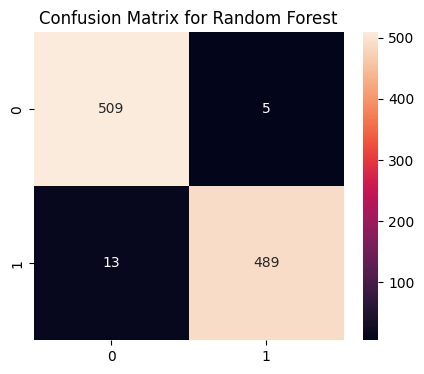

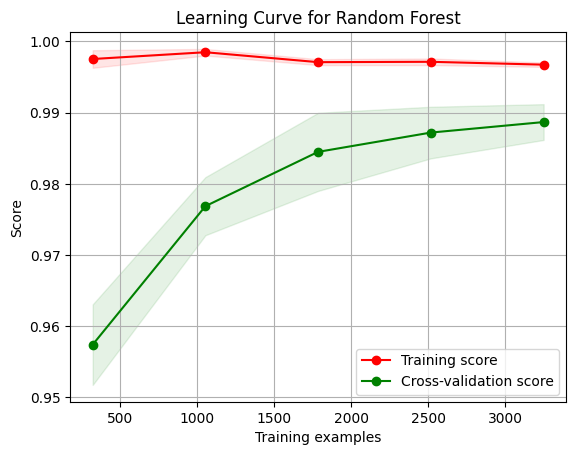

In [50]:
pipe = Pipeline([("rf", RandomForestClassifier(class_weight='balanced'))])

skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= 17)

param_grid_list = {'rf__n_estimators': [100, 150],
                  'rf__criterion': ['entropy', 'gini'],
                  'rf__min_samples_split': [2, 3],
                  'rf__min_samples_leaf': [1, 2],
                  'rf__max_features': [None, 'sqrt', 'log2']}

grid = GridSearchCV(pipe, param_grid=param_grid_list, cv=skf, n_jobs=-1, verbose=True)

# Evaluate the model
best_model_rf = evaluate_model(grid, X_train, y_train, X_test, y_test, skf, 'Random Forest')

In [38]:
importances = best_model_rf.named_steps['rf'].feature_importances_
indices = np.argsort(importances)[::-1]

features_names = X_train.columns

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature - {features_names[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. feature - email_match_from_return-path (0.25693261629944153)
2. feature - length_from (0.1804957609734542)
3. feature - domain_match_from_reply-to (0.11286201558801091)
4. feature - date_comp_date_received (0.07306841650533563)
5. feature - domain_match_return-path_reply-to (0.07124827641764553)
6. feature - domain_match_message-id_return-path (0.05355430491943675)
7. feature - domain_match_from_return-path (0.04660240490213696)
8. feature - domain_match_message-id_sender (0.035278193801505424)
9. feature - domain_match_sender_from (0.03278803225555727)
10. feature - email_match_from_reply-to (0.03202663741579338)
11. feature - domain_match_to_from (0.027805508506247627)
12. feature - domain_match_message-id_from (0.023195165729131068)
13. feature - num_servers_blacklisted (0.022034625148602327)
14. feature - num_recipients_to (0.011580823544500048)
15. feature - domain_match_message-id_reply-to (0.007124127763414597)
16. feature - host_blacklisted (0.00423187795231

In [27]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_model_rf, X_train, y_train, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

# Display permutation importance
for idx in sorted_idx[::-1]:
    print(f"Feature: {X_train.columns[idx]}, Importance: {result.importances_mean[idx]}")

Feature: length_from, Importance: 0.16147218119153126
Feature: email_match_from_return-path, Importance: 0.1522648941408173
Feature: domain_match_from_reply-to, Importance: 0.10231413096996549
Feature: domain_match_message-id_sender, Importance: 0.07570162481536184
Feature: domain_match_message-id_return-path, Importance: 0.055883801083210206
Feature: domain_match_from_return-path, Importance: 0.05216642048252089
Feature: date_comp_date_received, Importance: 0.03786312161496795
Feature: domain_match_message-id_from, Importance: 0.03707533234859671
Feature: num_servers_blacklisted, Importance: 0.028729689807976345
Feature: domain_match_return-path_reply-to, Importance: 0.020580994583948777
Feature: email_match_from_reply-to, Importance: 0.015041851304775944
Feature: domain_match_to_from, Importance: 0.00960118168389953
Feature: num_recipients_to, Importance: 0.0007877892663712305
Feature: host_blacklisted, Importance: 0.0005416051206302175
Feature: domain_match_sender_from, Importance: 

In [28]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(df_X, df_Y, random_state=42)

# Convert the result into a DataFrame for easy analysis
mi_df = pd.DataFrame({
    'Feature': df_X.columns,
    'Mutual Information': mi
}).sort_values(by='Mutual Information', ascending=False)

# Display the top features by Mutual Information
print(mi_df.head(10))


                              Feature  Mutual Information
8        email_match_from_return-path            0.330261
1                         length_from            0.301835
21         domain_match_from_reply-to            0.204010
6             date_comp_date_received            0.116220
14  domain_match_return-path_reply-to            0.107265
7           email_match_from_reply-to            0.092679
22               domain_match_to_from            0.068101
12     domain_match_message-id_sender            0.058387
24            num_servers_blacklisted            0.054867
17           domain_match_sender_from            0.054504


In [29]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# Scale the data to make sure all values are non-negative
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_X)

# Perform the chi-squared test
chi_scores = chi2(X_scaled, df_Y)

# Create a DataFrame to view the scores and p-values
chi_df = pd.DataFrame({
    'Feature': df_X.columns,
    'Chi-Squared Score': chi_scores[0],  # chi2 returns (chi2 statistic, p-value)
    'p-value': chi_scores[1]
}).sort_values(by='Chi-Squared Score', ascending=False)

# Display the top features by Chi-Squared Score
print(chi_df.head(10))

                              Feature  Chi-Squared Score        p-value
8        email_match_from_return-path        1768.997404   0.000000e+00
21         domain_match_from_reply-to        1172.466253  5.877712e-257
14  domain_match_return-path_reply-to         765.213197  1.974916e-168
7           email_match_from_reply-to         597.234992  6.686713e-132
22               domain_match_to_from         518.036306  1.131803e-114
24            num_servers_blacklisted         415.591766   2.223117e-92
12     domain_match_message-id_sender         364.706327   2.659580e-81
17           domain_match_sender_from         339.858738   6.849122e-76
13   domain_match_message-id_reply-to         283.345853   1.401174e-63
23         domain_match_to_message-id         140.552486   2.015577e-32


In [51]:
from sklearn.model_selection import cross_val_score

cross_val_scores = cross_val_score(RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=2, min_samples_leaf=1, max_features='sqrt', random_state=42)
, X_train, y_train, cv=10, scoring='accuracy')
print(f'Cross-validated accuracy: {cross_val_scores.mean()*100:.2f}%')

Cross-validated accuracy: 98.79%


### Decision Tree:

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'dt__criterion': 'entropy', 'dt__max_features': 'sqrt', 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2} 

Pipeline(steps=[('dt',
                 DecisionTreeClassifier(criterion='entropy',
                                        max_features='sqrt'))])
Model: Decision Tree
Accuracy on Test Set: 0.9862204724409449, Precision: 0.986286414880522, Recall: 0.9862204724409449, F1 Score: 0.9862190303023385
False Negative Rate: 0.0199203187250996
ROC-AUC Score: 0.9866991179251865


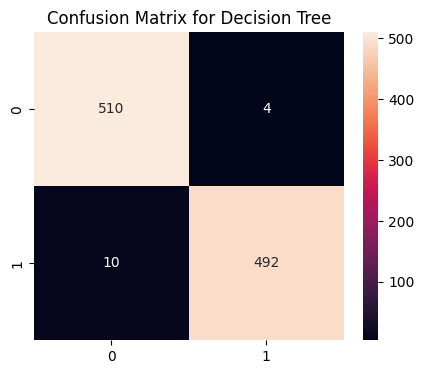

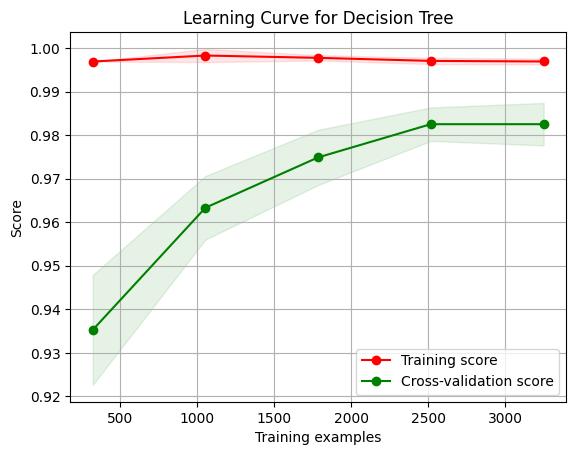

In [51]:
# Decision Tree Pipeline
pipe_dt = Pipeline([("dt", DecisionTreeClassifier())])

skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= 17)

param_grid_dt = {'dt__criterion': ['entropy', 'gini'],
                 'dt__min_samples_split': [2, 3],
                 'dt__min_samples_leaf': [1, 2],
                 'dt__max_features': [None, 'sqrt', 'log2']}

grid_dt = GridSearchCV(pipe_dt, param_grid=param_grid_dt, cv=skf, n_jobs=-1, verbose=True)

# Evaluate the Decision Tree model
best_model_dt = evaluate_model(grid_dt, X_train, y_train, X_test, y_test, 5, 'Decision Tree')

### Logistic Regression:

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'lr__C': 10, 'lr__penalty': 'l1'} 

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(C=10, penalty='l1', solver='liblinear'))])
Model: Logistic Regression
Accuracy on Test Set: 0.9478346456692913, Precision: 0.9507268203862392, Recall: 0.9478346456692913, F1 Score: 0.94772453284662
False Negative Rate: 0.09362549800796813
ROC-AUC Score: 0.9717879454942874


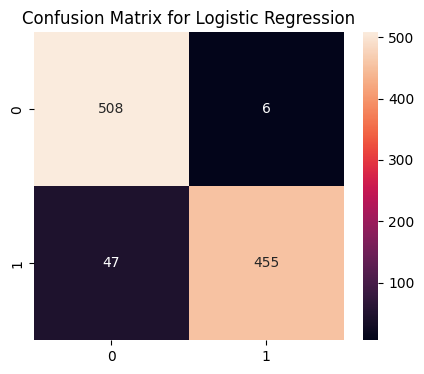

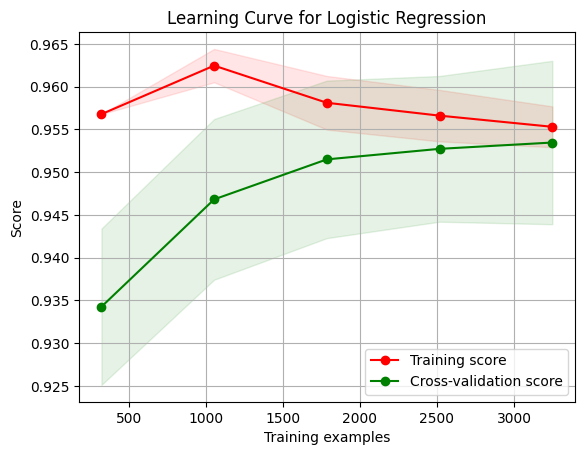

In [52]:
# Logistic Regression Pipeline
pipe_lr = Pipeline([("scaler", StandardScaler()),("lr", LogisticRegression(solver='liblinear'))])

param_grid_lr = {'lr__penalty': ['l1', 'l2'],
                 'lr__C': [0.01, 0.1, 1, 10, 100]}

grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid_lr, cv=skf, n_jobs=-1, verbose=True)

# Evaluate the Logistic Regression model
best_model_lr = evaluate_model(grid_lr, X_train, y_train, X_test, y_test, 5, 'Logistic Regression')


### Gradient Boosted Regression Trees (GBRT):

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'gb__learning_rate': 1, 'gb__max_depth': 7, 'gb__n_estimators': 200} 

Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1, max_depth=7,
                                            n_estimators=200))])
Model: Gradient Boosted Regression Trees
Accuracy on Test Set: 0.9901574803149606, Precision: 0.9901574803149606, Recall: 0.9901574803149606, F1 Score: 0.9901574803149606
False Negative Rate: 0.0099601593625498
ROC-AUC Score: 0.9966069573844698


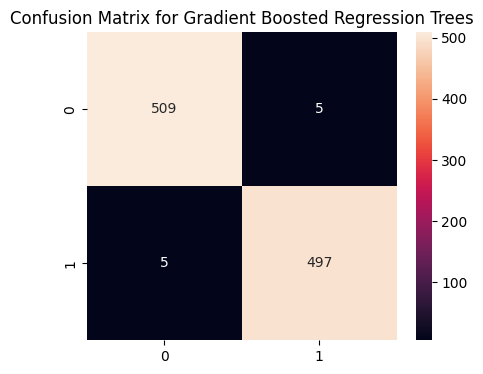

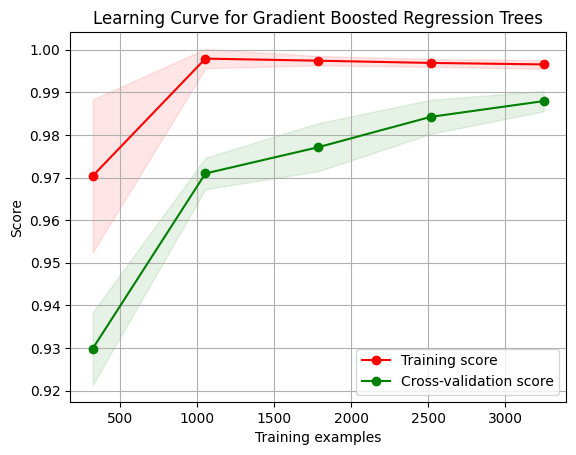

In [53]:
# Gradient Boosted Regression Trees Pipeline
pipe_gb = Pipeline([("gb", GradientBoostingClassifier())])

param_grid_gb = {'gb__n_estimators': [100, 200],
                 'gb__learning_rate': [0.01, 0.1, 1],
                 'gb__max_depth': [3, 5, 7]}

grid_gb = GridSearchCV(pipe_gb, param_grid=param_grid_gb, cv=skf, n_jobs=-1, verbose=True)

# Evaluate the Gradient Boosted Regression Trees model
best_model_gb = evaluate_model(grid_gb, X_train, y_train, X_test, y_test, 5, 'Gradient Boosted Regression Trees')


### Naive Bayes (Gaussian):

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'gnb__var_smoothing': 1e-08} 

Pipeline(steps=[('scale', StandardScaler()),
                ('gnb', GaussianNB(var_smoothing=1e-08))])
Model: Naive Bayes (Gaussian)
Accuracy on Test Set: 0.8779527559055118, Precision: 0.8985168952326554, Recall: 0.8779527559055118, F1 Score: 0.8761689116019824
False Negative Rate: 0.23904382470119523
ROC-AUC Score: 0.9637268048428853


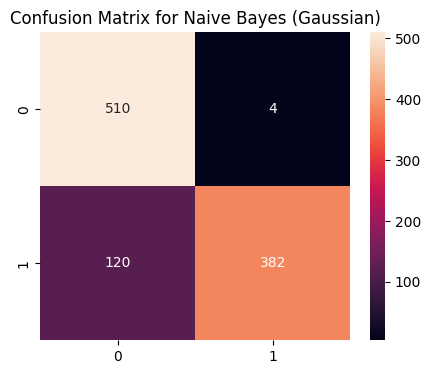

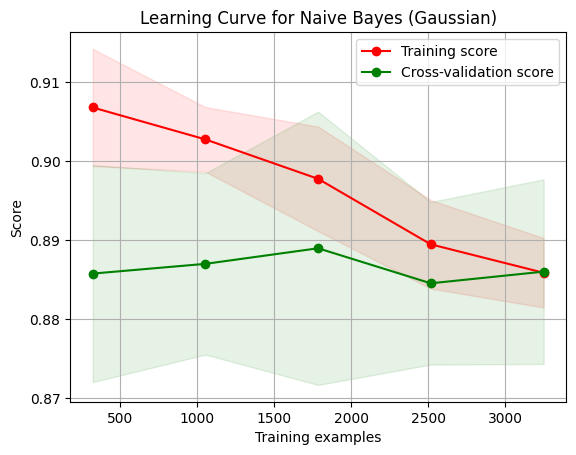

In [54]:
# Naive Bayes Pipeline
pipe_nb = Pipeline([("scale", StandardScaler()),("gnb", GaussianNB())])

param_grid_gnb = {'gnb__var_smoothing': [1E-9, 1E-10, 1E-8]}

grid_nb = GridSearchCV(pipe_nb, param_grid=param_grid_gnb, cv=skf, n_jobs=-1, verbose=True)

# Evaluate the Naive Bayes model
best_model_nb = evaluate_model(grid_nb, X_train, y_train, X_test, y_test, 5, 'Naive Bayes (Gaussian)')


### K-Nearest Neighbors (KNN):

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'knn__algorithm': 'auto', 'knn__leaf_size': 15, 'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'} 

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(leaf_size=15, metric='manhattan', p=1,
                                      weights='distance'))])
Model: K-Nearest Neighbors
Accuracy on Test Set: 0.985236220472441, Precision: 0.985385565178881, Recall: 0.985236220472441, F1 Score: 0.9852335161559398
False Negative Rate: 0.02390438247011952
ROC-AUC Score: 0.9918632861549909


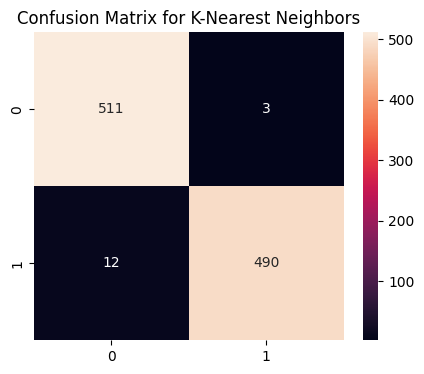

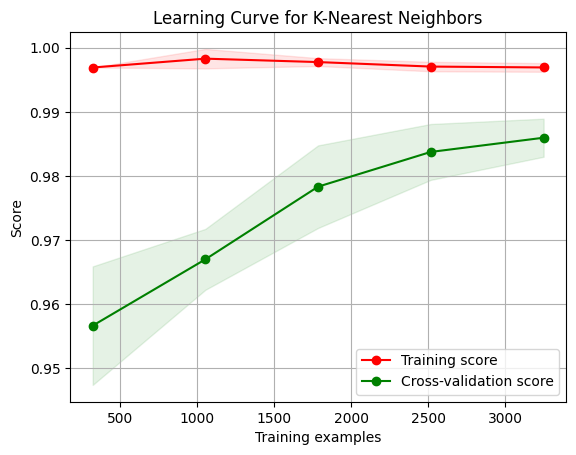

In [55]:
# K-Nearest Neighbors Pipeline
pipe_knn = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])

param_grid_knn = {'knn__n_neighbors': [1, 5, 7],
                  'knn__weights': ['uniform', 'distance'],
                  'knn__p': [1, 2],
                  'knn__algorithm': ['auto'],
                  'knn__leaf_size': [15, 30, 45],
                  'knn__metric': ['euclidean', 'manhattan']}

grid_knn = GridSearchCV(pipe_knn, param_grid=param_grid_knn, cv=skf, n_jobs=-1, verbose=True)

# Evaluate the K-Nearest Neighbors model
best_model_knn = evaluate_model(grid_knn, X_train, y_train, X_test, y_test, 5, 'K-Nearest Neighbors')


### Multilayer Perceptron Neural Network (MLP):

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'} 

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=0.001,
                               hidden_layer_sizes=(100, 50), max_iter=1000))])
Model: Multilayer Perceptron Neural Network
Accuracy on Test Set: 0.9753937007874016, Precision: 0.9758002988619059, Recall: 0.9753937007874016, F1 Score: 0.9753840398176149
False Negative Rate: 0.0398406374501992
ROC-AUC Score: 0.9926345202846203


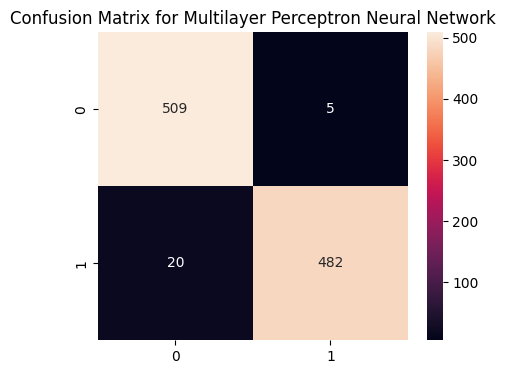

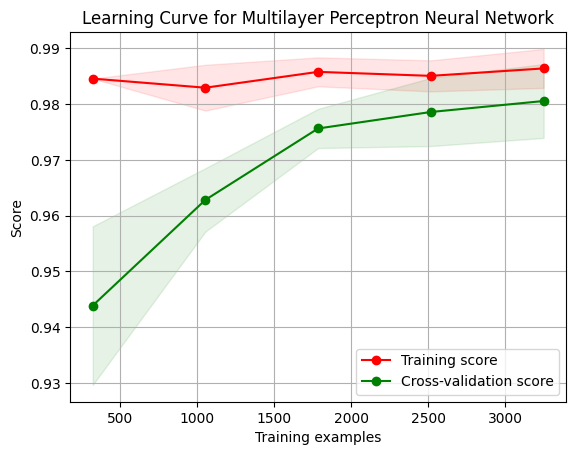

In [56]:
from sklearn.neural_network import MLPClassifier

# Multilayer Perceptron Pipeline
pipe_mlp = Pipeline([("scaler", StandardScaler()),("mlp", MLPClassifier(max_iter=1000))])

param_grid_mlp = {'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50)],
                  'mlp__learning_rate': ['constant', 'adaptive'],
                  'mlp__activation': ['relu', 'tanh'],
                  'mlp__solver': ['adam', 'sgd'],
                  'mlp__alpha': [0.0001, 0.001, 0.01]}

grid_mlp = GridSearchCV(pipe_mlp, param_grid=param_grid_mlp, cv=skf, n_jobs=-1, verbose=True)

# Evaluate the Multilayer Perceptron Neural Network model
best_model_mlp = evaluate_model(grid_mlp, X_train, y_train, X_test, y_test, 5, 'Multilayer Perceptron Neural Network')


### Support Vector Machine:

In [84]:
# Define the pipeline
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC())
])

skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= 17)

# Define the hyperparameters for SVM
param_grid_list_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__gamma': ['scale', 'auto'],
    'svm__degree': [3, 4, 5]  # Only relevant for 'poly' kernel
}

# Initialize GridSearchCV
grid_svm = GridSearchCV(pipe_svm, param_grid=param_grid_list_svm, cv=skf, n_jobs=-1, verbose=True)

# Evaluate the model
best_model = evaluate_model(grid_svm, X_train, y_train, X_test, y_test, 5, 'SVM')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(layers.Conv1D(
        filters=hp.Int('filters', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        input_shape=(X_train.shape[1], 1)))
    model.add(layers.SimpleRNN(
        hp.Int('rnn_units', min_value=32, max_value=128, step=32),
        return_sequences=False))
    model.add(layers.Dense(
        hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Total number of trials to run
    executions_per_trial=1,  # Number of models to build for each trial
    directory='my_dir',
    project_name='rnn_tuning')

# Start the tuning process
tuner.search(X_train, y_train, epochs=10, validation_split=0.1, verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]

# Get predictions
predictions = (best_model.predict(X_test) > 0.5).astype("int32")

# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test)
f1 = f1_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f'Test Accuracy: {accuracy*100:.2f}%')
print(f'F1 Score: {f1*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'ROC AUC: {roc_auc*100:.2f}%')
print('Confusion Matrix:')
print(conf_matrix)

# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best Hyperparameters:')
print(best_hyperparameters.values)

## Model Comparison

In [57]:
# After running all models, convert results to DataFrame
model_comparison_df = pd.DataFrame(model_comparison)

# Display the results
model_comparison_df

,Model,Accuracy,Precision,Recall,F1 Score,False Negative Rate,ROC-AUC
0,Random Forest,0.982283,0.982400,0.982283,0.982281,0.025896,0.997107
1,Decision Tree,0.986220,0.986286,0.986220,0.986219,0.019920,0.986699
2,Logistic Regression,0.947835,0.950727,0.947835,0.947725,0.093625,0.971788
3,Gradient Boosted Regression Trees,0.990157,0.990157,0.990157,0.990157,0.009960,0.996607
4,Naive Bayes (Gaussian),0.877953,0.898517,0.877953,0.876169,0.239044,0.963727
5,K-Nearest Neighbors,0.985236,0.985386,0.985236,0.985234,0.023904,0.991863
6,Multilayer Perceptron Neural Network,0.975394,0.975800,0.975394,0.975384,0.039841,0.992635


In [60]:
# Save models

# Random Forest
joblib.dump(best_model_rf, 'models/best_model_rf.pkl')

# Decision Tree
joblib.dump(best_model_dt, 'models/best_model_dt.pkl')

# Logistic Regression
joblib.dump(best_model_lr, 'models/best_model_lr.pkl')

# Gradient Boosted Regression Trees
joblib.dump(best_model_gb, 'models/best_model_gb.pkl')

# Naive Bayes
joblib.dump(best_model_nb, 'models/best_model_nb.pkl')

# K-Nearest Neighbors
joblib.dump(best_model_knn, 'models/best_model_knn.pkl')

# Multilayer Perceptron Neural Network
joblib.dump(best_model_mlp, 'models/best_model_mlp.pkl')

['models/best_model_mlp.pkl']